<a href="https://colab.research.google.com/github/RRaakha/Data-Science-Internship/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**



In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
import re
import string

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize





In [57]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!pip install palettable


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 4.7 MB/s eta 0:00:00


**Conduct EDA**

In [4]:
df = pd.read_csv('/content/sentiment_analysis.csv')
df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


In [5]:
df.describe()

,Year,Month,Day
count,499.000000,499.000000,499.000000
mean,2020.394790,6.084168,15.693387
std,2.830991,3.652711,8.804673
min,2010.000000,1.000000,1.000000
25%,2019.000000,2.000000,8.000000
50%,2021.000000,6.000000,15.000000
75%,2023.000000,9.000000,22.000000
max,2023.000000,12.000000,31.000000


In [6]:
df['Platform'] = df['Platform'].replace(' Facebook ', 'Facebook')

In [12]:
df['Platform'] = df['Platform'].replace(' Twitter  ', 'Twitter')

In [13]:
plat = df.groupby('Platform').count()['text'].reset_index().sort_values(by='text',ascending=False)
plat.style.background_gradient(cmap='Blues')

,Platform,text
0,Instagram,171
1,Facebook,169
2,Twitter,159


In [14]:
temp = df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,199
2,positive,166
0,negative,134


<Axes: xlabel='sentiment', ylabel='count'>

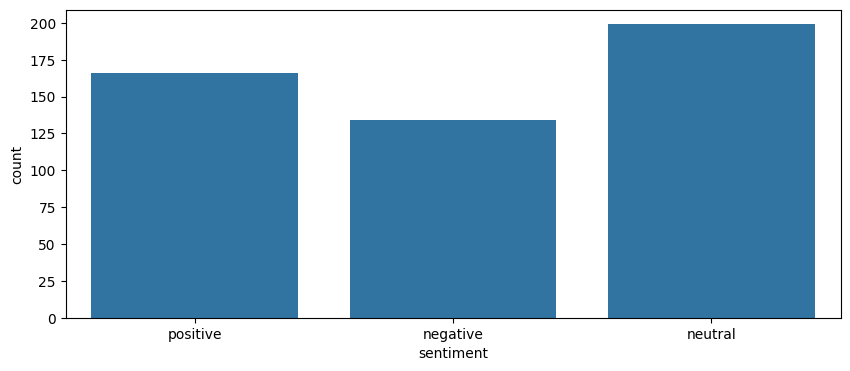

In [15]:
plt.figure(figsize=(10,4))
sns.countplot(x='sentiment',data=df)

In [16]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [49]:
df['id'] = range(1, len(df) + 1)


In [50]:
platform_sentiment=df.groupby(by=["Platform","sentiment"]).count().reset_index()
platform_sentiment.head()

,Platform,sentiment,Year,Month,Day,Time of Tweet,text,Num_word_text,temp_list,id
0,Instagram,negative,49,49,49,49,49,49,49,49
1,Instagram,neutral,65,65,65,65,65,65,65,65
2,Instagram,positive,57,57,57,57,57,57,57,57
3,Facebook,negative,54,54,54,54,54,54,54,54
4,Facebook,neutral,54,54,54,54,54,54,54,54


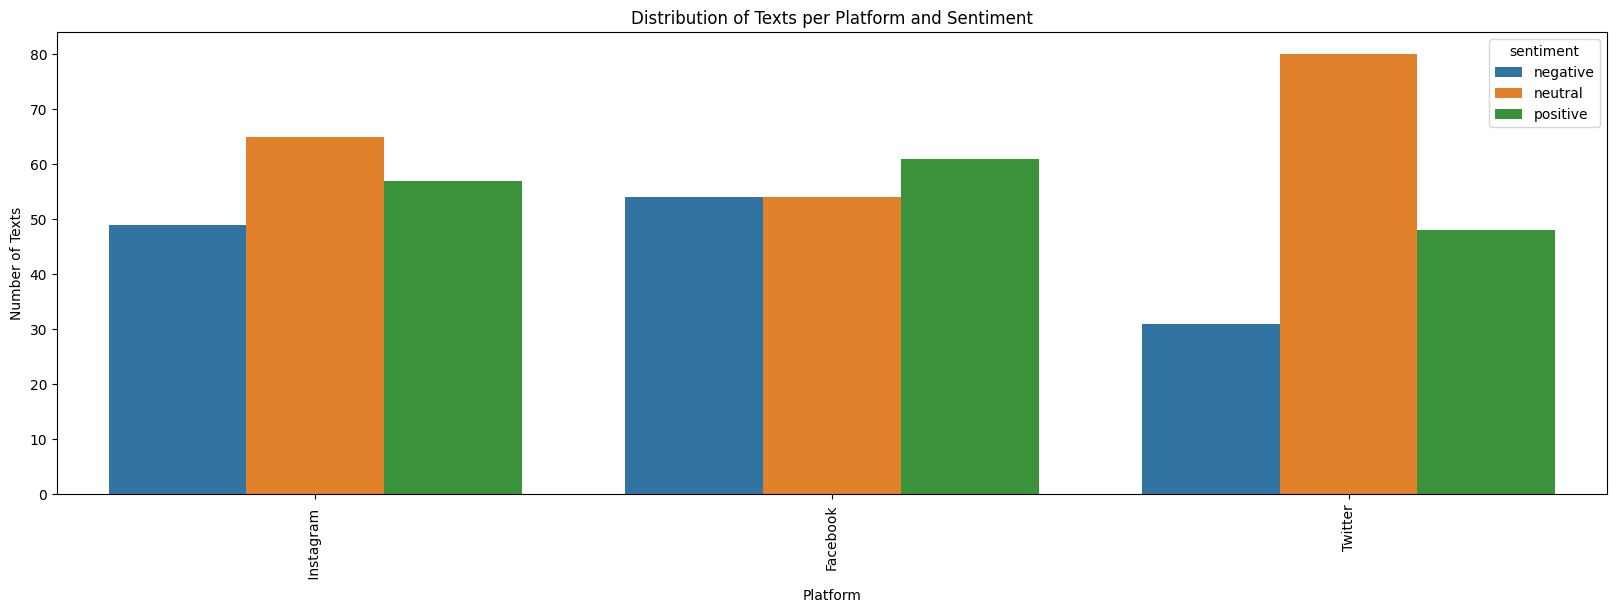

In [51]:
plt.figure(figsize=(20,6))
sns.barplot(data=platform_sentiment,x="Platform",y = 'id',hue="sentiment")
plt.xticks(rotation=90)
plt.xlabel("Platform")
plt.ylabel("Number of Texts")
plt.title("Distribution of Texts per Platform and Sentiment");

In [17]:
df['Num_word_text'] = df['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text

In [18]:
df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform,Num_word_text
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter,7
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook,11
2,2017,8,18,night,Don't angry me,negative,Facebook,3
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook,14
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram,8


In [19]:
hist_data = [df['Num_word_text']]

group_labels = ['Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data,group_labels, show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=800,
    height=400,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

<ipython-input-20-8c5df46a3b5d>:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




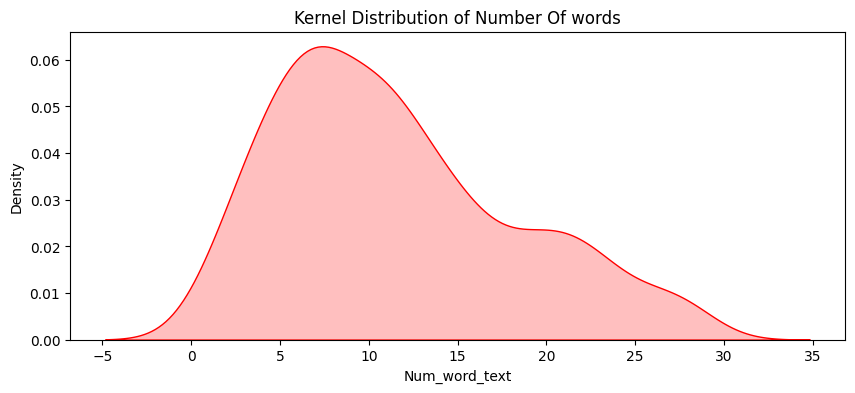

In [20]:
plt.figure(figsize=(10,4))
p1=sns.kdeplot(df['Num_word_text'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')


In [21]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [22]:
df['text'] = df['text'].apply(lambda x:clean_text(x))
df.head()


,Year,Month,Day,Time of Tweet,text,sentiment,Platform,Num_word_text
0,2018,8,18,morning,what a great day looks like dream,positive,Twitter,7
1,2018,8,18,noon,i feel sorry i miss you here in the sea beach,positive,Facebook,11
2,2017,8,18,night,dont angry me,negative,Facebook,3
3,2022,6,8,morning,we attend in the class just for listening teac...,negative,Facebook,14
4,2022,6,8,noon,those who want to go let them go,negative,Instagram,8


In [23]:
df['temp_list'] =df['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,i,208
1,to,185
2,the,147
3,a,99
4,you,98
5,my,97
6,and,93
7,im,78
8,for,74
9,it,74


In [24]:

fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [25]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
df['temp_list'] = df['temp_list'].apply(lambda x:remove_stopword(x))

In [26]:
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,day,43
2,love,32
3,know,30
4,like,28
5,going,28
6,go,26
7,dont,25
8,happy,24
9,really,22
10,today,21


In [27]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [28]:
Positive_sent = df[df['sentiment']=='positive']
Negative_sent = df[df['sentiment']=='negative']
Neutral_sent = df[df['sentiment']=='neutral']

In [29]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,day,28
1,im,26
2,love,26
3,happy,21
4,really,15
5,amazing,13
6,mothers,12
7,like,11
8,good,10
9,great,8


In [30]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [31]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,dont,16
2,go,10
3,like,10
4,sorry,8
5,want,7
6,miss,7
7,going,7
8,tomorrow,7
9,well,6
10,feel,6


In [32]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

In [33]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='cool')

,Common_words,count
1,know,17
2,back,14
3,going,14
4,today,13
5,go,12
6,got,10
7,day,10
8,big,9
9,get,9
10,days,8


In [34]:

fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

In [35]:
raw_text = [word for word_list in df['temp_list'] for word in word_list]

In [98]:
def words_unique(sentiment,numwords,raw_words):
    allother = []
    for item in df[df.sentiment != sentiment]['temp_list']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    specific = [x for x in raw_text if x not in allother]

    mycounter = Counter()

    for item in df[df.sentiment == sentiment]['temp_list']:
        for word in item:
            mycounter[word] += 1
    keep = list(specific)

    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]

    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    return Unique_words


In [37]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,mothers,12
1,world,7
2,song,6
3,thank,6
4,wonderful,5
5,kids,4
6,followed,4
7,party,4
8,nice,4
9,awesome,4


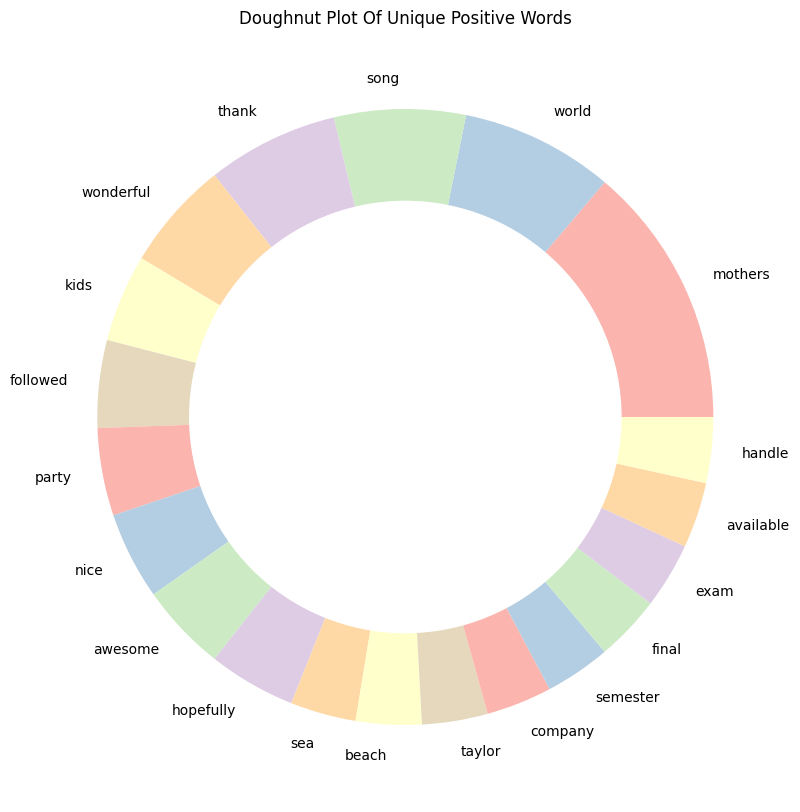

In [38]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Doughnut Plot Of Unique Positive Words')
plt.show()

In [39]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,class,4
1,lost,4
2,depressed,4
3,missed,4
4,running,3
5,music,3
6,hardly,3
7,gloomy,3
8,sleeping,3
9,hate,3


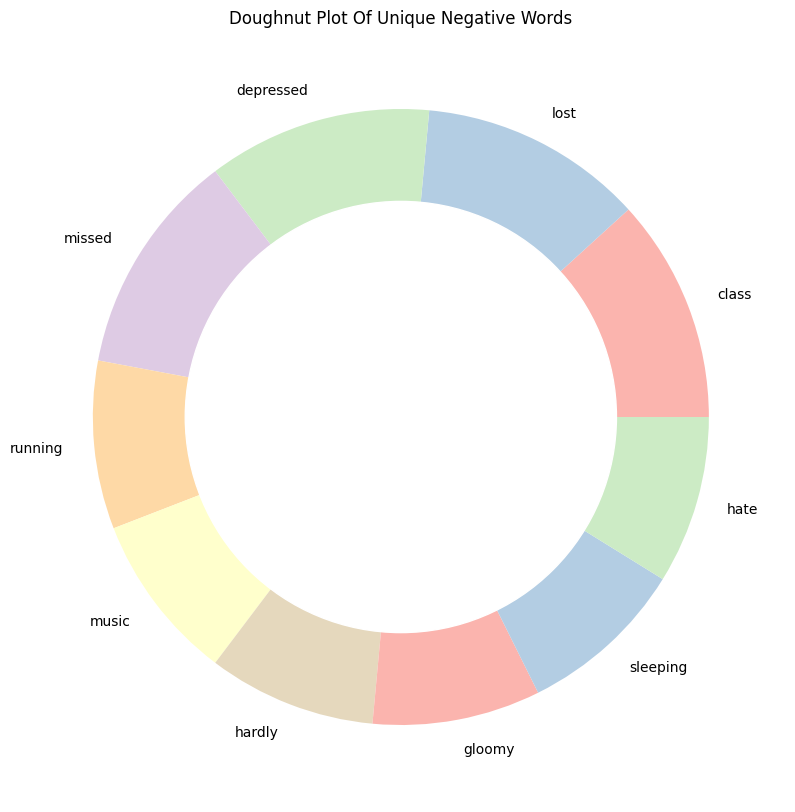

In [40]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Doughnut Plot Of Unique Negative Words')
plt.show()

In [41]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,coffee,6
1,waiting,5
2,something,4
3,later,4
4,old,4
5,grabbing,4
6,making,4
7,breakfast,4
8,sass,4
9,remember,4


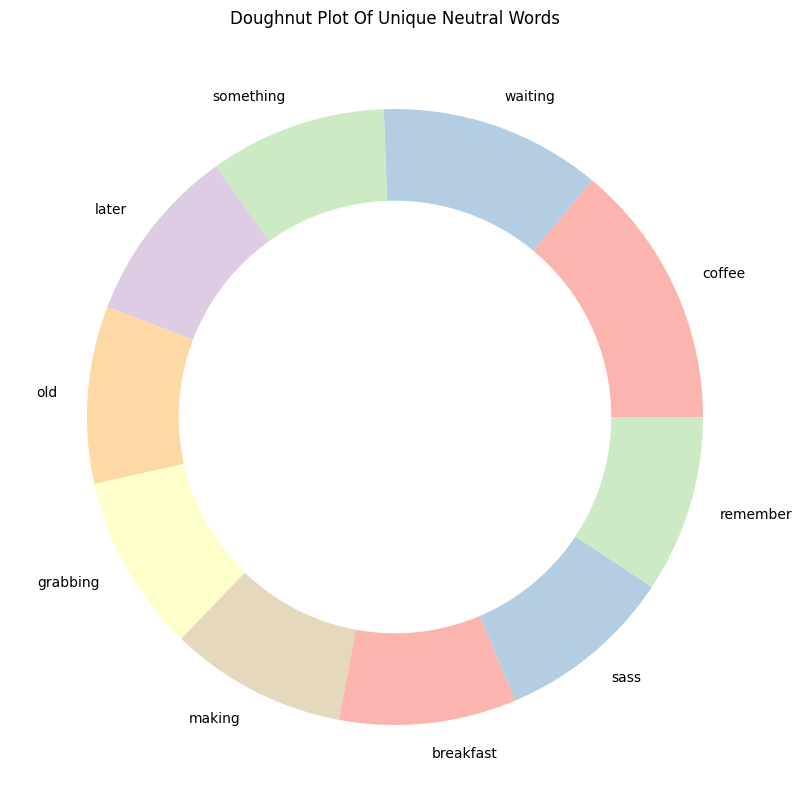

In [42]:

from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Doughnut Plot Of Unique Neutral Words')
plt.show()

In [43]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=400,
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()


In [44]:
from google.colab import files
uploaded = files.upload()


Saving sr.PNG to sr.PNG


In [45]:
from PIL import Image
pos_mask = np.array(Image.open("sr.PNG"))

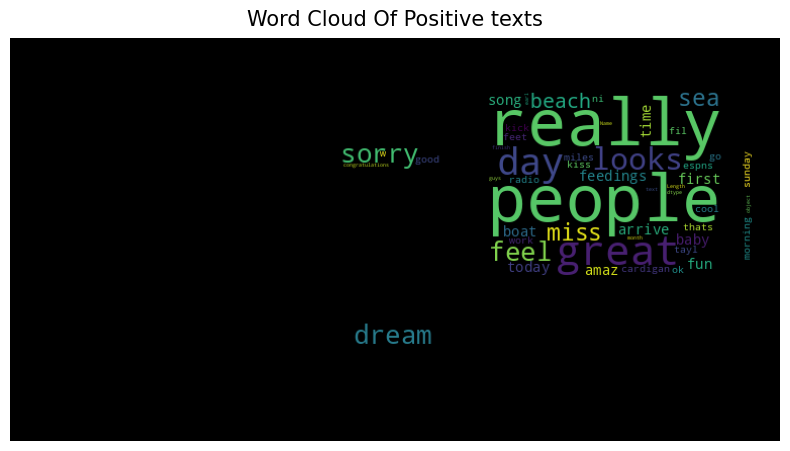

In [46]:
plot_wordcloud(Positive_sent.text,mask=pos_mask,title="Word Cloud Of Positive texts",color='black',title_size=15, max_words=200, max_font_size=150, figure_size=(8, 8.0))

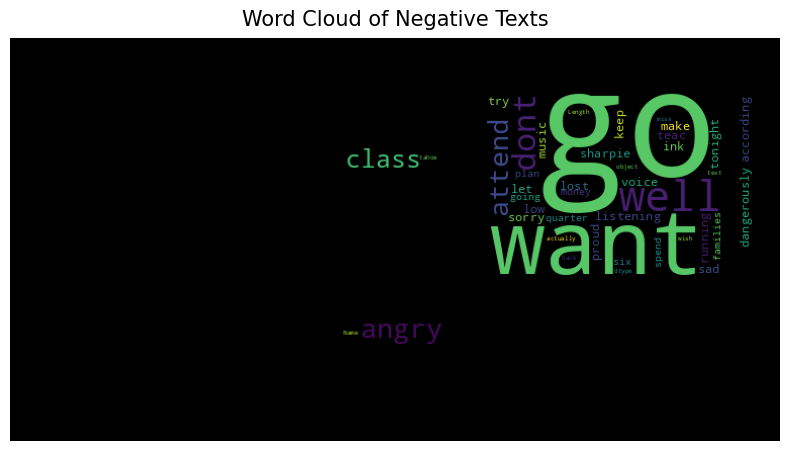

In [47]:
plot_wordcloud(Negative_sent.text,mask=pos_mask,title="Word Cloud of Negative Texts",color='black',title_size=15, max_words=200, max_font_size=150, figure_size=(8, 8.0))


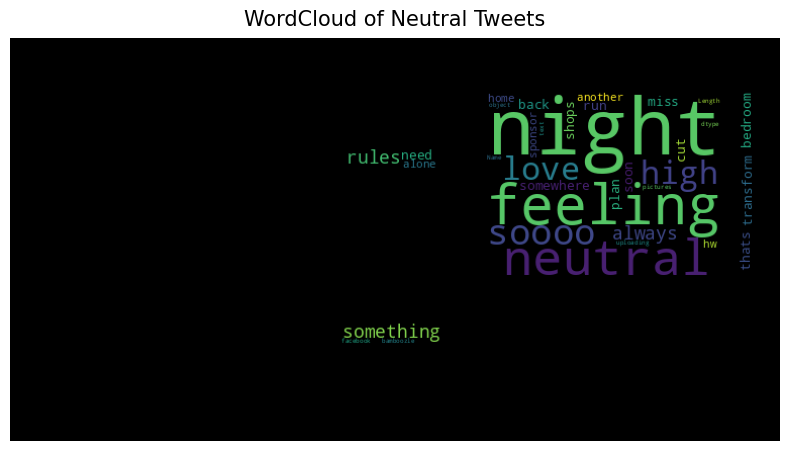

In [48]:

plot_wordcloud(Neutral_sent.text,mask=pos_mask,title="WordCloud of Neutral Tweets",color='black',title_size=15, max_words=200, max_font_size=150, figure_size=(8, 8.0))

**Preprocessing and Tokenization**

In [52]:
stop_words = ["the", "and", "is", "in", "to", "for", "of"]
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=stop_words, #English Stopwords
    ngram_range=(1, 1) #analysis of one word
)

In [67]:
x = df['text']
y = df['sentiment']

In [68]:
#Creation of encoding related to train dataset
x_bow = bow_counts.fit_transform(x.fillna('').str.lower())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



**Logistic Regression Model**

In [84]:
x_train,x_test, y_train, y_test = train_test_split(x_bow,y, test_size=0.3, random_state=23)

In [97]:
# Logistic regression
model = LogisticRegression(C=1, solver="liblinear",max_iter=200)
model.fit(x_train, y_train)
# Prediction
test_pred = model.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, test_pred) * 100)

Accuracy:  69.33333333333334


In [86]:
le = LabelEncoder()
y_train_bow = le.fit_transform(y_train)
y_test_bow = le.fit_transform(y_test)

**XGBoost Model**

In [94]:
%%time
XGB=XGBClassifier(objective="multi:softmax",n_estimators=1000,colsample_bytree=0.6, subsample=0.6)
XGB.fit(x_train, y_train_bow)
# Prediction
test_pred_2 = XGB.predict(x_test)
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_2) * 100)

Accuracy:  70.66666666666667
CPU times: user 3.43 s, sys: 71.8 ms, total: 3.51 s
Wall time: 4.96 s
